<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/bidilstm_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [16]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [18]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

'wget' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [19]:
def get_data():
    data_file = "station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [20]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [21]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

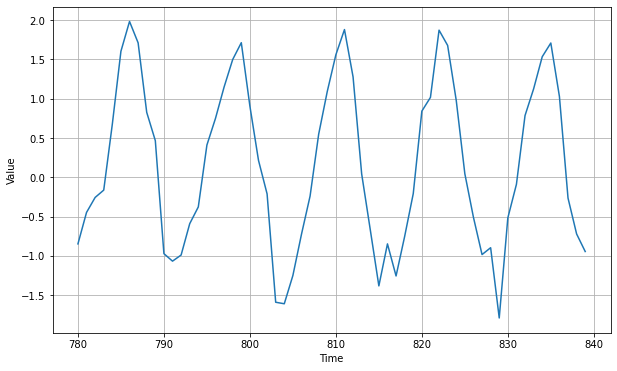

In [22]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, input_shape=[None, 1], return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, validation_data=valid_dataset)

Epoch 1/100


C:\Users\camjt\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


38/38 [==============================] - 8s 63ms/step - loss: 0.4546 - mae: 0.8651 - val_loss: 0.5231 - val_mae: 0.9348
Epoch 2/100
38/38 [==============================] - 1s 15ms/step - loss: 0.4538 - mae: 0.8641 - val_loss: 0.5222 - val_mae: 0.9337
Epoch 3/100
38/38 [==============================] - 1s 16ms/step - loss: 0.4529 - mae: 0.8631 - val_loss: 0.5213 - val_mae: 0.9326
Epoch 4/100
38/38 [==============================] - 1s 16ms/step - loss: 0.4521 - mae: 0.8620 - val_loss: 0.5205 - val_mae: 0.9315
Epoch 5/100
38/38 [==============================] - 1s 14ms/step - loss: 0.4512 - mae: 0.8610 - val_loss: 0.5196 - val_mae: 0.9305
Epoch 6/100
38/38 [==============================] - 1s 16ms/step - loss: 0.4504 - mae: 0.8600 - val_loss: 0.5188 - val_mae: 0.9294
Epoch 7/100
38/38 [==============================] - 1s 17ms/step - loss: 0.4496 - mae: 0.8590 - val_loss: 0.5179 - val_mae: 0.9283
Epoch 8/100
38/38 [==============================] - 1s 15ms/step - loss: 0.4487 - mae: 

Epoch 63/100
38/38 [==============================] - 1s 15ms/step - loss: 0.4037 - mae: 0.8034 - val_loss: 0.4697 - val_mae: 0.8694
Epoch 64/100
38/38 [==============================] - 1s 14ms/step - loss: 0.4028 - mae: 0.8023 - val_loss: 0.4688 - val_mae: 0.8683
Epoch 65/100
38/38 [==============================] - 1s 15ms/step - loss: 0.4020 - mae: 0.8013 - val_loss: 0.4679 - val_mae: 0.8672
Epoch 66/100
38/38 [==============================] - 1s 16ms/step - loss: 0.4011 - mae: 0.8003 - val_loss: 0.4670 - val_mae: 0.8661
Epoch 67/100
38/38 [==============================] - 1s 14ms/step - loss: 0.4003 - mae: 0.7993 - val_loss: 0.4661 - val_mae: 0.8650
Epoch 68/100
38/38 [==============================] - 1s 17ms/step - loss: 0.3994 - mae: 0.7982 - val_loss: 0.4652 - val_mae: 0.8639
Epoch 69/100
38/38 [==============================] - 1s 16ms/step - loss: 0.3985 - mae: 0.7972 - val_loss: 0.4643 - val_mae: 0.8628
Epoch 70/100
38/38 [==============================] - 1s 17ms/step - 

In [25]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [26]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 2s 42ms/step


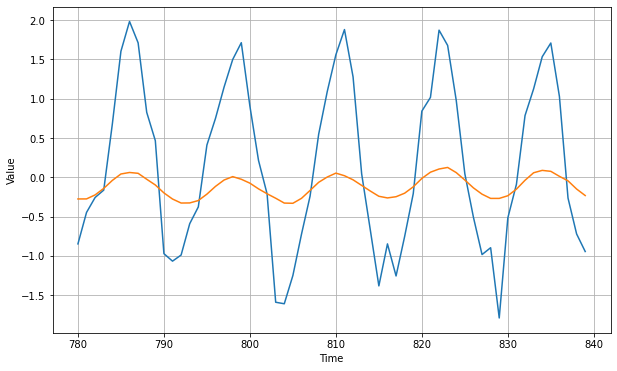

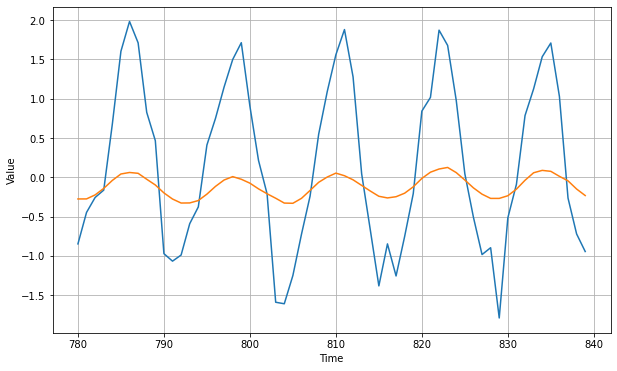

In [27]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()


In [28]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.8264501


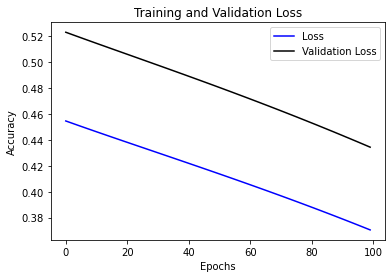

<Figure size 432x288 with 0 Axes>

In [29]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
